In [1]:
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
#Import image
batch_size=32
train_data = tf.keras.preprocessing.image_dataset_from_directory("./small_data", validation_split=0.2, subset="training", seed=1, batch_size=batch_size, image_size=(32,32))
val_data = tf.keras.preprocessing.image_dataset_from_directory("./small_data", validation_split=0.2, subset="validation", seed=1, batch_size=batch_size,  image_size=(32,32))

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [3]:
class_names = train_data.class_names

In [4]:
#In case the data is not standardized, standardize it here
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

In [5]:
#Create model
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
250/250 [==============================] - 3s 10ms/step - loss: 0.1724 - accuracy: 0.9183 - val_loss: 0.0033 - val_accuracy: 0.9995
Epoch 2/5
250/250 [==============================] - 2s 9ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 3/5
250/250 [==============================] - 2s 9ms/step - loss: 3.5776e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 4/5
250/250 [==============================] - 2s 9ms/step - loss: 1.6026e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9995
Epoch 5/5
250/250 [==============================] - 2s 9ms/step - loss: 9.1481e-05 - accuracy: 1.0000 - val_loss: 9.1337e-04 - val_accuracy: 0.9995


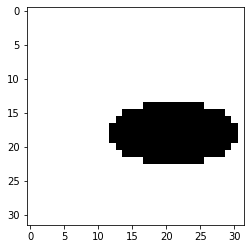

This image most likely belongs to circle with a 100.00 percent confidence.


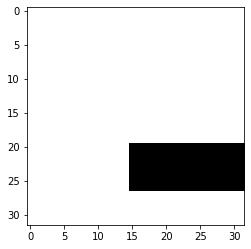

This image most likely belongs to not_circle with a 100.00 percent confidence.


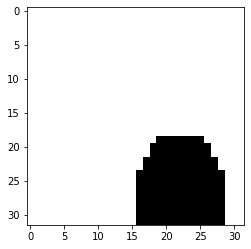

This image most likely belongs to circle with a 100.00 percent confidence.


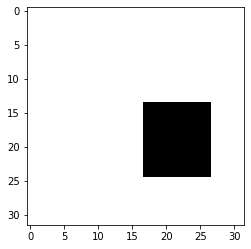

This image most likely belongs to not_circle with a 100.00 percent confidence.


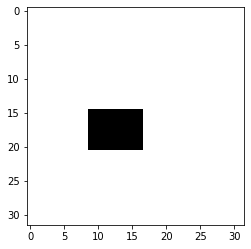

This image most likely belongs to not_circle with a 100.00 percent confidence.


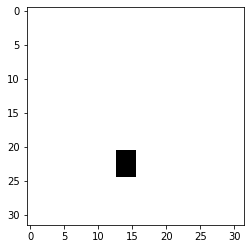

This image most likely belongs to not_circle with a 99.86 percent confidence.


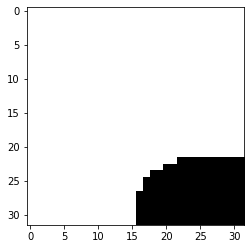

This image most likely belongs to circle with a 100.00 percent confidence.


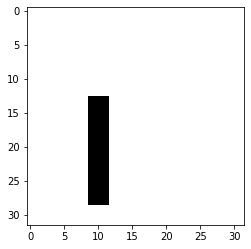

This image most likely belongs to not_circle with a 100.00 percent confidence.


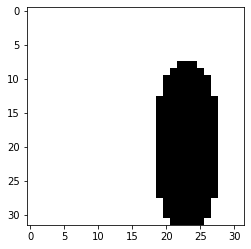

This image most likely belongs to circle with a 100.00 percent confidence.


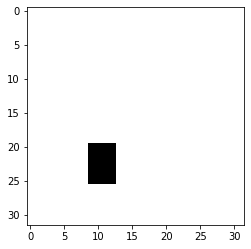

This image most likely belongs to not_circle with a 100.00 percent confidence.


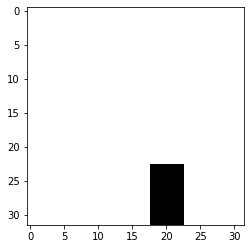

This image most likely belongs to not_circle with a 99.98 percent confidence.


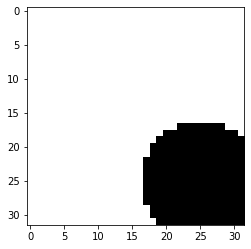

This image most likely belongs to circle with a 100.00 percent confidence.


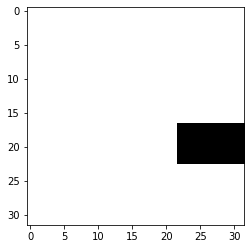

This image most likely belongs to not_circle with a 99.99 percent confidence.


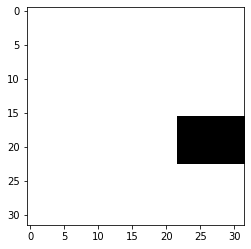

This image most likely belongs to not_circle with a 100.00 percent confidence.


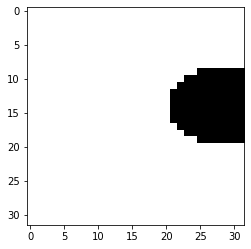

This image most likely belongs to circle with a 100.00 percent confidence.


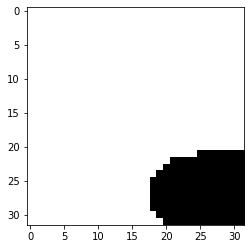

This image most likely belongs to circle with a 100.00 percent confidence.


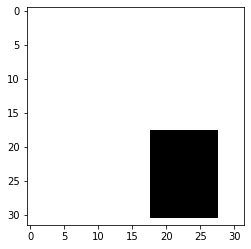

This image most likely belongs to not_circle with a 100.00 percent confidence.


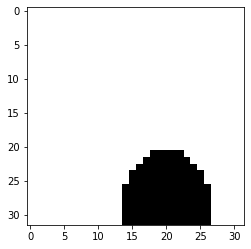

This image most likely belongs to circle with a 100.00 percent confidence.


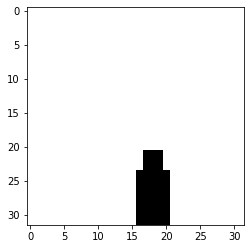

This image most likely belongs to circle with a 100.00 percent confidence.


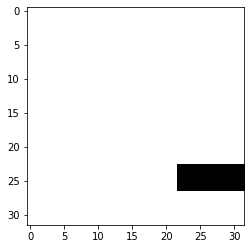

This image most likely belongs to not_circle with a 99.99 percent confidence.


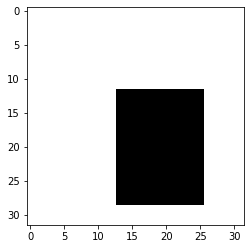

This image most likely belongs to not_circle with a 100.00 percent confidence.


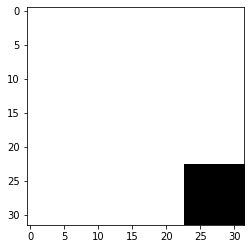

This image most likely belongs to not_circle with a 99.98 percent confidence.


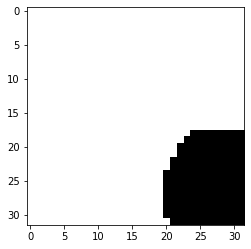

This image most likely belongs to circle with a 100.00 percent confidence.


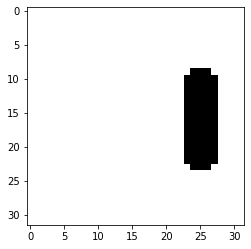

This image most likely belongs to circle with a 100.00 percent confidence.


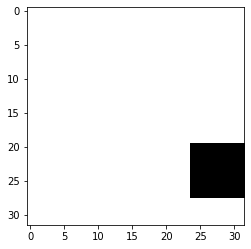

This image most likely belongs to not_circle with a 100.00 percent confidence.


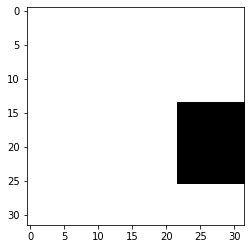

This image most likely belongs to not_circle with a 100.00 percent confidence.


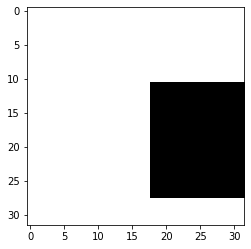

This image most likely belongs to not_circle with a 100.00 percent confidence.


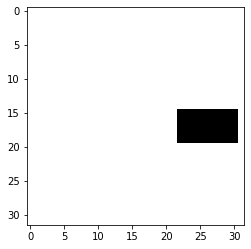

This image most likely belongs to not_circle with a 99.99 percent confidence.


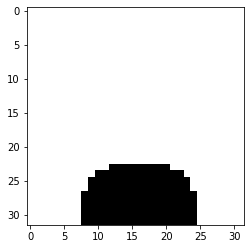

This image most likely belongs to circle with a 100.00 percent confidence.


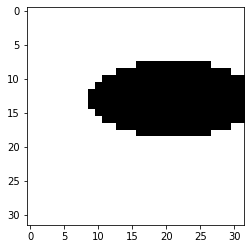

This image most likely belongs to circle with a 100.00 percent confidence.


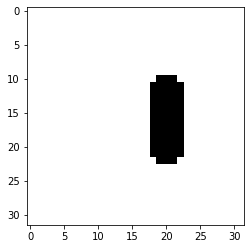

This image most likely belongs to circle with a 100.00 percent confidence.


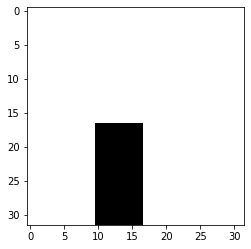

This image most likely belongs to not_circle with a 100.00 percent confidence.


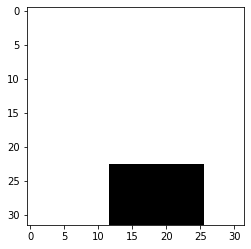

This image most likely belongs to not_circle with a 100.00 percent confidence.


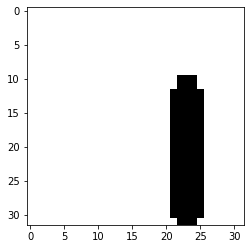

This image most likely belongs to circle with a 99.97 percent confidence.


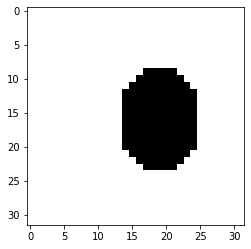

This image most likely belongs to circle with a 100.00 percent confidence.


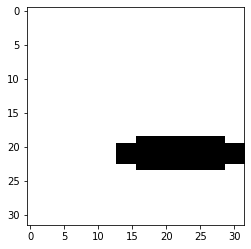

This image most likely belongs to circle with a 100.00 percent confidence.


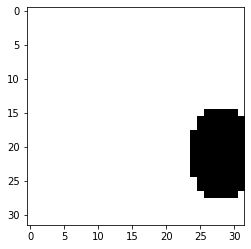

This image most likely belongs to circle with a 100.00 percent confidence.


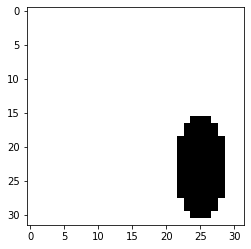

This image most likely belongs to circle with a 100.00 percent confidence.


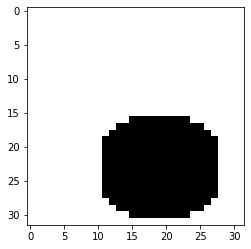

This image most likely belongs to circle with a 100.00 percent confidence.


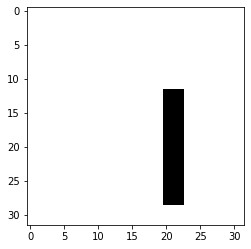

This image most likely belongs to not_circle with a 100.00 percent confidence.


In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np

#Test images that are in the format of the images that we will actually use
test_folder = "./small_test_data"

for filename in os.listdir(test_folder):
    
    path = os.path.join(test_folder, filename)
    
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(32, 32)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    plt.imshow(img)
    plt.show()

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [7]:
#Finally, save the model
model.save("./src/model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./src/model/assets


In [8]:
#Now convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("./src/model")
tflite_model = converter.convert()

# Save the model
with open('target_model.tflite', 'wb') as f:
  f.write(tflite_model)